#  Insurance Linear Regression Forecast by Ammar Altalibi

Uses 'Medical Cost Personal' dataset from Kaggle

Link to dataset: 
https://www.kaggle.com/mirichoi0218/insurance

The data is comprised of insurance costs for over 1,300 patients and includes information such as age, BMI, charges, etc.


---



This is my linear regression model of insurance costs. I used simple machine learning code to apply a regression model in order to predict charges based on the historical data. I first start by importing all necessary libraries and extensions before loading the dataset.

## Loading the data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn import preprocessing
from sklearn import utils
from math import sqrt

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
data = pd.read_csv('/content/gdrive/MyDrive/Datasets/insurance.csv', sep = ',')

data['sex'] =data['sex'].astype('category')
data['region'] =data['region'].astype('category')
data['smoker'] =data['smoker'].astype('category')

data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We then create 2 new columns in order to classify the age and BMI columns. This code is based on the classifiers used by Salik Husseini for his EDA [(link to his work)](https://www.kaggle.com/salikhussaini49/medical-insurance-eda))

In [3]:
def Bmi_Classifier(row):
    if row['bmi'] < 18.5:
        return "underweight"
    elif row['bmi'] < 25:
        return "normal"
    elif row['bmi'] < 30:
        return "overweight"
    else:
        return "obese"

def Age_Classifier(row):
    if row['age'] < 17:
        return "child"
    elif row['age'] < 31:
        return "adult"
    elif row['age'] < 46:
        return "middle-aged"
    else:
        return "old-aged"

data['bmi_status'] = data.apply(Bmi_Classifier, axis=1)
data['age_status'] = data.apply(Age_Classifier, axis=1)

data.head()

,age,sex,bmi,children,smoker,region,charges,bmi_status,age_status
0,19,female,27.900,0,yes,southwest,16884.92400,overweight,adult
1,18,male,33.770,1,no,southeast,1725.55230,obese,adult
2,28,male,33.000,3,no,southeast,4449.46200,obese,adult
3,33,male,22.705,0,no,northwest,21984.47061,normal,middle-aged
4,32,male,28.880,0,no,northwest,3866.85520,overweight,middle-aged


Now that we are done loading the data, we can begin exploring it to find anything interesting



---



## Data Exploration

### How many smokers and non-smokers are in the dataset?

In [4]:
print('There are',data[data['smoker'] == 'no']['age'].count(),'non-smokers in the dataset')
print('There are',data[data['smoker'] == 'yes']['age'].count(),'smokers in the dataset')

There are 1064 non-smokers in the dataset
There are 274 smokers in the dataset


### What are the averages for the columns based on whether the patient is a smoker or not?

In [5]:
smokedata = data.groupby('smoker').mean().round(2)
smokedata.head()

,age,bmi,children,charges
smoker,,,,
no,39.39,30.65,1.09,8434.27
yes,38.51,30.71,1.11,32050.23


We can see here that the average cost for a smoker is 32,050 dollars which is **3.8 times** more than the average cost of non-smokers, with 8,434 dollars.

Lets look at how the data is distributed betweeen the number of children and the charges based if the patient smokes or not.

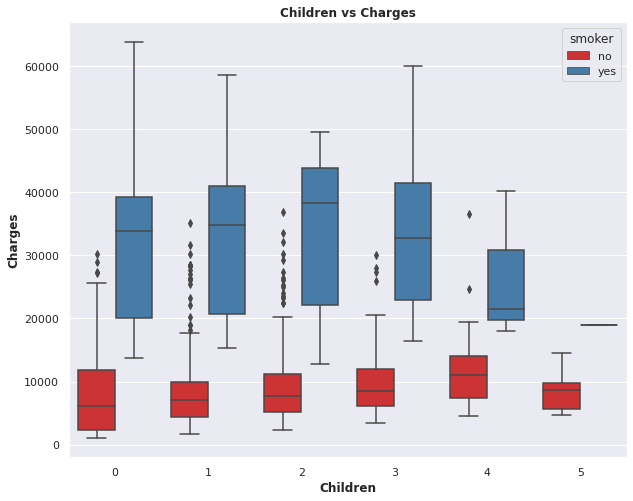

In [6]:
fig = plt.figure(figsize = (10,8));
sns.set_theme()

sns.boxplot(data = data, 
            x = 'children', 
            y = 'charges', 
            hue = 'smoker', 
            palette = 'Set1');

plt.xlabel('Children', fontweight = 'bold');
plt.ylabel('Charges', fontweight = 'bold');
plt.title('Children vs Charges', fontweight = 'bold');

There doesn't seem to be a significant difference when the number of children increase, but what about regional differences?

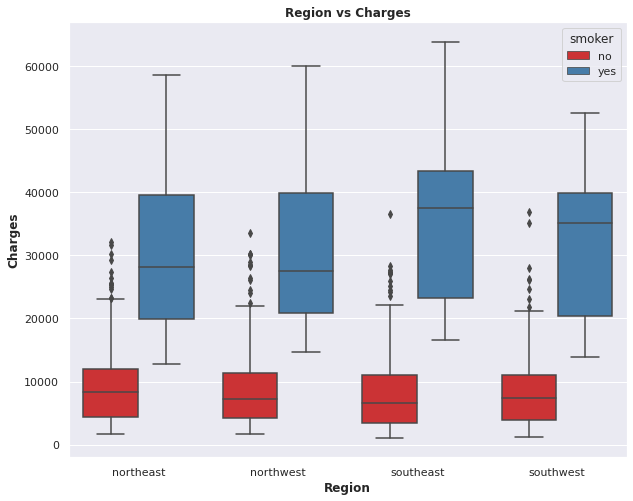

In [7]:
fig = plt.figure(figsize = (10,8));

sns.boxplot(data = data, 
            x = 'region', 
            y = 'charges', 
            hue = 'smoker', 
            palette = 'Set1');

plt.xlabel('Region', fontweight = 'bold');
plt.ylabel('Charges', fontweight = 'bold');
plt.title('Region vs Charges', fontweight = 'bold');

Again, there doesn't seem to be much of a difference. We can see that non-smokers never pass the 40,000 dollar level, while smokers never go below 10,000. 

Lets create a pairplot to see if there are any strong correlations

### Pairplot

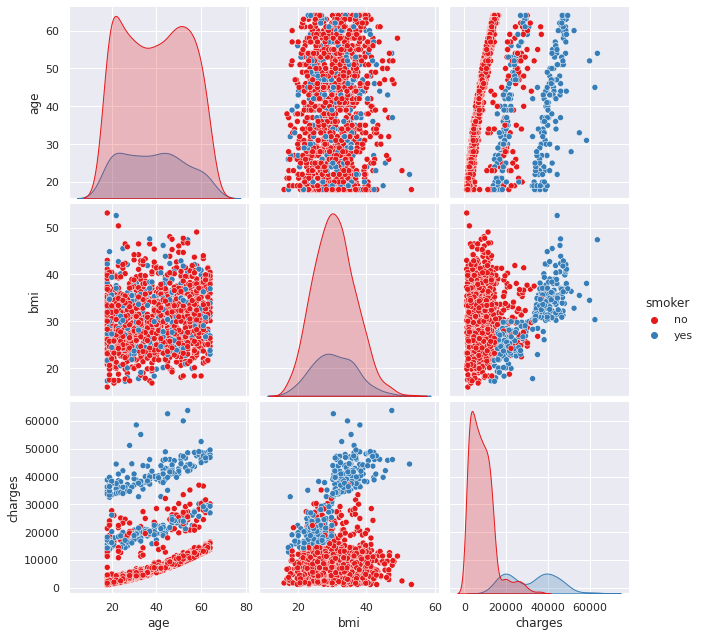

In [8]:
sns.pairplot(data[['age','bmi','charges','smoker']], 
             hue = 'smoker', 
             height = 3, 
             palette = 'Set1');

The BMI and charges graph looks very interesting, and it seems to have a very strong positive correlation when it comes to smokers, lets take a closer look

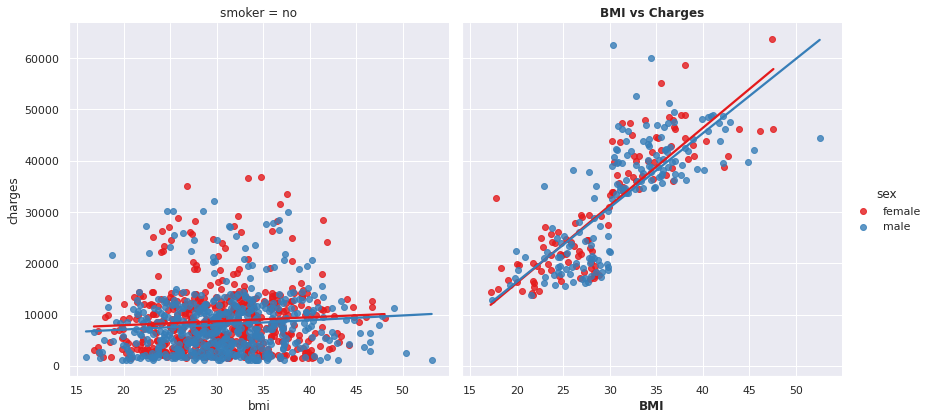

In [9]:
sns.lmplot(data = data, 
           x = 'bmi', 
           y = 'charges', 
           col = 'smoker', 
           hue = 'sex',
           palette = 'Set1',
           height = 6, 
           ci = None);

plt.xlabel('BMI', fontweight = 'bold');
plt.ylabel('Charges', fontweight = 'bold');
plt.title('BMI vs Charges', fontweight = 'bold');

While there doesn't seem to be any significant difference based on sex, there is a very obvious difference based on if the patient is a smoker or not. There is a very strong positive correlation, but what exactly is the number?

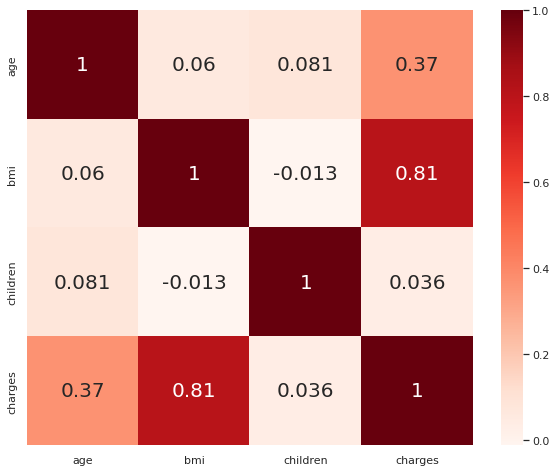

In [10]:
hm = data[data['smoker'] == 'yes'][['age','bmi','children','charges']].corr()

fig = plt.figure(figsize = (10,8))
sns.heatmap(hm, cmap = 'Reds', annot = True, annot_kws = {'size':20});

As expected, BMI has the highest correlation for smokers when it comes to charges, and we can now see that it has a value of 0.81 which is considered moderate to high.



---



## Linear Regression

I'll now begin working on the regression model, which will be based on smokers as opposed to non-smokers. This will make the model a bit more accurate, but will only be applicable when predicting future values for smokers.

### Creating numeric columns for the different categories

In [74]:
data2 = data[data['smoker'] == 'yes'][['sex', 'children', 'region', 'charges','bmi_status', 'age_status']]
new_data = pd.get_dummies(data2, columns = ['sex','children','region','bmi_status','age_status'])
new_data.head()

,charges,sex_female,sex_male,children_0,children_1,children_2,children_3,children_4,children_5,region_northeast,region_northwest,region_southeast,region_southwest,bmi_status_normal,bmi_status_obese,bmi_status_overweight,bmi_status_underweight,age_status_adult,age_status_middle-aged,age_status_old-aged
0,16884.9240,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
11,27808.7251,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
14,39611.7577,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
19,36837.4670,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
23,37701.8768,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0


### Building the Regression model

The training data will be 80% of the data, and the testing will use the remaining 20%

In [75]:


X = new_data.drop('charges', axis = 1).values
y = new_data['charges']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.80, test_size = 0.20, random_state = 15)

lm = LinearRegression(fit_intercept = True)
lm.fit(X_train, y_train);

y_pred = lm.predict(X_train)

Now that we have built our model, lets measure the accuracy



---



## Accuracy of the model

We measure the accuracy of the model using:

- Overall score
- Root Mean Squared Error
- Mean Absolute Error

In [111]:
print('The accuracy on the training data:',lm.score(X_train, y_train).round(3))
print('The accuracy on the testing data:',lm.score(X_test, y_test).round(3))
print(' ')
print('Root Mean Squared Error (RMSE)')
print('The RMSE on the training dataset:', round(sqrt(mean_squared_error(y_train, y_pred)),3))
print('The RMSE on the testing dataset:', round(sqrt(mean_squared_error(y_test, lm.predict(X_test))),3))
print(' ')
print('Mean Absolute Error (MAE)')
print('The MAE on the training dataset:', mean_absolute_error(y_train, y_pred).round(3))
print('The MAE on the testing dataset:', mean_absolute_error(y_test, lm.predict(X_test)).round(3))

The accuracy on the training data: 0.879
The accuracy on the testing data: 0.802
 
Root Mean Squared Error (RMSE)
The RMSE on the training dataset: 3998.677
The RMSE on the testing dataset: 5203.348
 
Mean Absolute Error (MAE)
The MAE on the training dataset: 2640.628
The MAE on the testing dataset: 3287.832


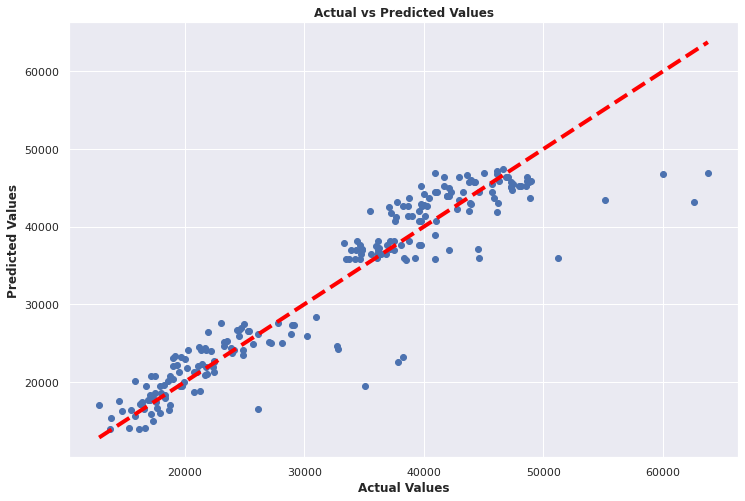

In [77]:
plt.figure(figsize = (12,8))
plt.scatter(y_train, y_pred);

plt.plot([y_train.min(), y_train.max()], 
         [y_train.min(), y_train.max()], 
         'k--', 
         c = 'red',
         lw = 4);

plt.xlabel('Actual Values', fontweight = 'bold');
plt.ylabel('Predicted Values', fontweight = 'bold');
plt.title('Actual vs Predicted Values', fontweight = 'bold');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


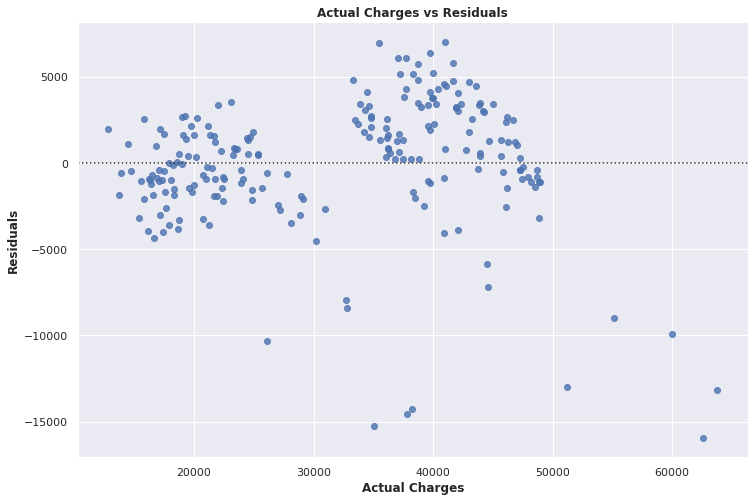

In [78]:
plt.figure(figsize = (12,8));

sns.residplot(y_train, y_pred, line_kws={"color": "red"});

plt.xlabel('Actual Charges', fontweight = 'bold');
plt.ylabel('Residuals', fontweight = 'bold');
plt.title('Actual Charges vs Residuals', fontweight = 'bold');



---



## Predicting Insurance Costs

Now that we have a succesful model, lets apply it and predict the costs based on whatever parameters we set

In [80]:
X2 = new_data.drop('charges', axis = 1)

Inter = lm.intercept_
Coeff = lm.coef_
Coeff = Coeff.reshape(-1,19)

Coeff_df = pd.DataFrame(Coeff, columns = [X2.columns])
Coeff_df

,sex_female,sex_male,children_0,children_1,children_2,children_3,children_4,children_5,region_northeast,region_northwest,region_southeast,region_southwest,bmi_status_normal,bmi_status_obese,bmi_status_overweight,bmi_status_underweight,age_status_adult,age_status_middle-aged,age_status_old-aged
0,1.986810e+17,1.986810e+17,1.691206e+16,1.691206e+16,1.691206e+16,1.691206e+16,1.691206e+16,1.691206e+16,-2.233922e+17,-2.233922e+17,-2.233922e+17,-2.233922e+17,2.618087e+17,2.618087e+17,2.618087e+17,2.618087e+17,-6.897029e+17,-6.897029e+17,-6.897029e+17


Now that we have all our coefficients and the intercept, we can create our prediction forumla. By changing the values for the 5 variables, we can predict the cost for the patient

In [110]:
sex = ['sex_female']
children = ['children_2']
region = ['region_southwest']
bmi_status = ['bmi_status_normal']
age_status = ['age_status_middle-aged']

pred1 = (Inter) + (Coeff_df[sex].values[0] * 1) + (Coeff_df[children].values[0] * 1) + (Coeff_df[region].values[0] * 1) + (Coeff_df[bmi_status].values[0] * 1) +(Coeff_df[age_status].values[0] * 1)

print('Your predicted insurance cost is', pred1[0].round(2), 'dollars')

Your predicted insurance cost is 20224.0 dollars




---



## Conclusion and Notes

While this model is relatively accurate, with over 80% accuracy, we must keep in mind that it can only be applied to smokers. If I attempt to use the same code and apply the model for the dataset, smokers and non-smokers, the accuracy drops to 70%.

Thank you for reading!
